# <center> Training Machine learning models </center>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
sns.set()
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.svm import LinearSVC, LinearSVR
#from thundersvm import SVC, SVR
from sklearn.svm import SVC, SVR
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.pipeline import *
from sklearn.kernel_approximation import Nystroem
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras import Sequential, backend as K
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras
from sklearn.base import BaseEstimator, TransformerMixin
import multiprocessing as mp
mp.set_start_method('forkserver')
%matplotlib inline

In [3]:
## load data from data.npz
def load_data():
    X_train = pd.read_pickle("./X_train.pkl")
    X_test  = pd.read_pickle("./X_test.pkl")
    with np.load('data.npz', allow_pickle=True) as npz_file:
        y_train_cla=pd.Series(npz_file['y_train_cla'] , name='book_rating_class')
        y_train_reg=pd.Series(npz_file['y_train_reg'] , name='book_rating_count_log')
        authors_df_train=pd.DataFrame(npz_file['authors_df_train'] , columns=npz_file['authors_to_keep'])
        genres_df_train=pd.DataFrame(npz_file['genres_df_train'] , columns=npz_file['genres_to_keep'])
        format_df_train=pd.DataFrame(npz_file['format_df_train'] , columns=npz_file['formats_to_keep'])
        title_df_train=pd.DataFrame(npz_file['title_df_train'] , columns=npz_file['title_columns'])
        desc_df_train=pd.DataFrame(npz_file['desc_df_train'] , columns=npz_file['desc_columns'])
        image_df_train=pd.DataFrame(npz_file['image_df_train'] , columns=npz_file['image_columns'])
        y_test_cla=pd.Series(npz_file['y_test_cla'] , name='book_rating_class')
        y_test_reg=pd.Series(npz_file['y_test_reg'] , name='book_rating_count_log')
        authors_df_test=pd.DataFrame(npz_file['authors_df_test'] , columns=npz_file['authors_to_keep'])
        genres_df_test=pd.DataFrame(npz_file['genres_df_test'] , columns=npz_file['genres_to_keep'])
        format_df_test=pd.DataFrame(npz_file['format_df_test'] , columns=npz_file['formats_to_keep'])
        title_df_test=pd.DataFrame(npz_file['title_df_test'] , columns=npz_file['title_columns'])
        desc_df_test=pd.DataFrame(npz_file['desc_df_test'] , columns=npz_file['desc_columns'])
        image_df_test=pd.DataFrame(npz_file['image_df_test'] , columns=npz_file['image_columns']) 
        authors_to_keep=npz_file['authors_to_keep']
        genres_to_keep=npz_file['genres_to_keep']
        formats_to_keep=npz_file['formats_to_keep']
        title_columns=npz_file['title_columns']
        desc_columns=npz_file['desc_columns']
        image_columns=npz_file['image_columns']
    return X_train,y_train_cla,y_train_reg, authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, image_df_train, X_test,y_test_cla,y_test_reg, authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, image_df_test, authors_to_keep, genres_to_keep, formats_to_keep, title_columns,desc_columns,image_columns
    #return X_train,y_train_cla,y_train_reg, authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, X_test,y_test_cla,y_test_reg, authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, authors_to_keep, genres_to_keep, formats_to_keep, title_columns,desc_columns,image_columns
X_train_base,y_train_cla,y_train_reg, authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, image_df_train, X_test_base,y_test_cla,y_test_reg, authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, image_df_test, authors_to_keep, genres_to_keep, formats_to_keep, title_columns,desc_columns,image_columns = load_data()
#X_train_base,y_train_cla,y_train_reg, authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, X_test_base,y_test_cla,y_test_reg, authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, authors_to_keep, genres_to_keep, formats_to_keep, title_columns,desc_columns,image_columns = load_data()
X_train = pd.concat((X_train_base.book_pages_log,authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train), axis=1)
X_test = pd.concat((X_test_base.book_pages_log,authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test), axis=1)
print(X_train.shape, X_test.shape)
#y_train_reg = y_train_reg#.apply(np.exp)
#y_test_reg = y_test_reg#.apply(np.exp)

(32234, 2325) (8059, 2325)


After loading data from disk, the helper functions and classes bellwo will be used in this notebook.

For classification : we will use accuracy and roc auc as performance metrics

For regression : we will use rmse as performance metric

In [4]:
# plot validation curve of a model
def plot_validation_curves(model, title, X, y, param1_name, param1_range, param2_name, param2_range):
    fig, axes = plt.subplots(1, len(param1_range), sharey=True , figsize=(15, 10))
    for i, val in enumerate(param1_range):
        model.set_params(**{param1_name:val})
        print(model)
        train_scores, valid_scores = validation_curve(model, X, y,cv=3,n_jobs=4, verbose=0, param_name=param2_name, param_range=param2_range)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(valid_scores, axis=1)
        test_scores_std = np.std(valid_scores, axis=1)
        if  len(param1_range) == 1:
            ax=axes
        else:
            ax=axes[i]
        ax.set_title(f"Validation Curve : {title} ({param1_name}={val})")
        ax.set_xlabel(f"{param2_name}")
        ax.set_ylabel("Score")
        ax.semilogx(param2_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=2)
        ax.fill_between(param2_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange", lw=2)
        ax.semilogx(param2_range, test_scores_mean, label="Cross-validation score",
                     color="navy", lw=2)
        ax.fill_between(param2_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2,
                         color="navy", lw=2)
    plt.legend(loc="best")
    plt.show()
    
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def auc(y_true, y_pred):
    return roc_auc_score(LabelBinarizer().fit_transform(y_true.values.reshape(-1, 1)), LabelBinarizer().fit_transform(y_pred.values.reshape(-1, 1)))

# class used to fit a model and choose best params from a grid using GridSearchCV
class ModelSelector:
    
    def __init__(self, models, grid, cla=True):
        self.models = models
        self.grid = grid
        self.cla=cla
        self.list = list(models.keys())
        self.results = {}

    def fit(self, X, y, cv_folds=3, scoring='accuracy'):
        if scoring == 'rmse':
            scorer = make_scorer(rmse, greater_is_better = False)
        elif scoring == 'auc':
            scorer = make_scorer(auc, greater_is_better = True)
        else:
            scorer='accuracy'
        for val in self.list:
            print('Fitting model :', val)
            model = self.models[val]
            grid = self.grid[val]
            cv = GridSearchCV(model, grid, cv=cv_folds,  scoring=scorer, return_train_score=True, n_jobs=3, verbose=10, iid=True, refit=True)
            cv.fit(X,y)
            self.results[val] = cv

    def scores(self, X, y):
        #scores details
        scores_details = []
        scores_best = []
        columns = ['model', 'params', 'mean_train_score', 'std_train_score', 'mean_val_score', 'std_val_score', 'best_test_score', 'best_test_auc_score']
        for key, cv in self.results.items():
            auc_score=np.nan
            means = np.abs(cv.cv_results_['mean_test_score'])
            stds = cv.cv_results_['std_test_score']
            means_tr = np.abs(cv.cv_results_['mean_train_score'])
            stds_tr = cv.cv_results_['std_train_score']
            all_params = cv.cv_results_['params']
            bi = cv.best_index_
            test_score = np.abs(cv.score(X, y))
            if self.cla:
                auc_score=auc(y, pd.Series(cv.predict(X)))
            scores_details += [ (key,params,mean_tr,std_tr,mean,std, np.nan, np.nan) for mean_tr, std_tr, mean, std, params in zip(means_tr, stds_tr, means, stds, all_params) ]
            scores_best += [(key, all_params[bi], means_tr[bi], stds_tr[bi], means[bi], stds[bi], test_score, auc_score)]

        return pd.DataFrame(scores_best,columns=columns), pd.DataFrame(scores_details,columns=columns)
    
    def score(self, model, X, y):
        return self.results[model].score(X, y)

    def predict(self, model, X):
        return self.results[model].predict(X)

# fit a neural network for classification    
def fit_nn(dl, X, y, X_t, y_t):
    np.random.seed(0)
    tf.set_random_seed(0)
    dl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    dl.fit( x=X, y=y,validation_split=0.1, batch_size=64, epochs=30
            ,callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]
            #,shuffle=True
            )
    (train_loss, train_accuracy) = dl.evaluate(X, y, batch_size=64)
    print("Train Accuracy :", train_accuracy)
    (test_loss, test_accuracy) = dl.evaluate(X_t, y_t, batch_size=64)
    print("Test Accuracy :", test_accuracy)
    y_hat = dl.predict(X)
    train_auc = roc_auc_score(y, y_hat)
    print("train AUC score", train_auc)
    y_hat = dl.predict(X_t)
    test_auc = roc_auc_score(y_t, y_hat)
    print("test AUC score", test_auc)
    return train_accuracy, train_auc, test_accuracy, test_auc, y_hat

# fit a neural network for regression
def fit_nn_reg(dl, X, y, X_t, y_t):
    np.random.seed(0)
    tf.set_random_seed(0)
    dl.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    dl.fit( x=X, y=y,validation_split=0.1, batch_size=64, epochs=50
            ,callbacks=[keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5)]
            #,shuffle=True
            )
    (train_loss, train_accuracy) = dl.evaluate(X, y, batch_size=64)
    print("Train MSE :",train_accuracy ,", RMSE :", np.sqrt(train_accuracy))
    (test_loss, test_accuracy) = dl.evaluate(X_t, y_t, batch_size=64)
    print("Test MSE :",test_accuracy ,", RMSE :", np.sqrt(test_accuracy))
    return np.sqrt(train_accuracy), np.nan, np.sqrt(test_accuracy), np.nan

# return a neural network model with one hidden layer
def nn_dl1(X,dim=4,act='softmax'):
    dl = Sequential()
    dl.add(Dense(units=128, activation='relu', input_dim=X.shape[1],
                 kernel_initializer=keras.initializers.VarianceScaling(scale=2.0, seed=0)
                 )
           )
    dl.add(keras.layers.Dropout(0.5))
    dl.add(Dense(dim, activation=act,
                 kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, seed=0)
                 )
           )
    print(dl.summary())
    return dl

# return a neural network model with two hidden layers
def nn_dl2(X, dim=4,act='softmax'):
    dl = Sequential()
    dl.add(Dense(units=256, activation='relu', input_dim=X.shape[1]))
    dl.add(keras.layers.Dropout(0.3))
    dl.add(Dense(units=128, activation='sigmoid', input_dim=X.shape[1]))
    dl.add(keras.layers.Dropout(0.3))
    dl.add(Dense(dim, activation=act))
    print(dl.summary())
    return dl

# fit a xgboost model for classification
def fit_xgb(X_train, y_train_cla, display_fi=True):
    dtrain = xgb.DMatrix(data=X_train, label=y_train_cla)
    #dtrain_reg = xgb.DMatrix(data=X_train, label=y_train_reg)
    dtest = xgb.DMatrix(data=X_test)
    params = {
        'max_depth': 6,
        'objective': 'multi:softprob', 
        'num_class': 4,
        'n_gpus': 0,
        'nthread': 16
    }
    model = xgb.train(params, dtrain) 
    pred = model.predict(dtest)
    tr_pred = model.predict(dtrain)
    s1 = roc_auc_score(y_train_cla_1h, tr_pred)
    s2 = accuracy_score(y_train_cla, np.argmax(tr_pred,axis=1))
    print ('train : auc score :%s, accuracy score :%s'%(s1,s2))
    s1_t = roc_auc_score(y_test_cla_1h, pred)
    s2_t = accuracy_score(y_test_cla, np.argmax(pred,axis=1))
    print ('test : auc score :%s, accuracy score :%s'%(s1_t,s2_t))
    print(confusion_matrix(y_test_cla, np.argmax(pred,axis=1)))
    if display_fi:
        fi = model.get_score(importance_type='gain')
        feature_importance(model,np.array(list(fi.values())), list(fi.keys()))
    return s2, s1, s2_t, s1_t

# fit a xgboost model for regression
def fit_xgb_reg(X_train, y_train_reg, display_fi=True):
    dtrain_reg = xgb.DMatrix(data=X_train, label=y_train_reg)
    dtest = xgb.DMatrix(data=X_test)
    params_reg = {
    'max_depth': 6,
    'n_gpus': 0,
    'nthread': 16
    }
    model_reg = xgb.train(params_reg, dtrain_reg)  
    pred_reg = model_reg.predict(dtest)
    train_reg=model_reg.predict(dtrain_reg)
    s2 = np.sqrt(mean_squared_error(y_test_reg, pred_reg))
    s1 = np.sqrt(mean_squared_error(y_train_reg, train_reg))
    print ('RMSE : train score :%s, test score :%s'%(s1,s2))
    if display_fi:
        fi = model_reg.get_score(importance_type='gain')
        feature_importance(model_reg,np.array(list(fi.values())), list(fi.keys()))
    return s2, np.nan, s1, np.nan

- The models and models_reg variables will contains our list of models to train for classification and regression respectively.

- The grid and grid_reg variables will contain a grid of hyperparameter values to choose from when tuning models

In [5]:
models = {
    'baseline' : DummyClassifier(),
    'LogisticRegression' : LogisticRegression(random_state=0,solver='saga',multi_class='auto'),
    'RandomForestClassifier': RandomForestClassifier(random_state=0),
    'SVC_linear': LinearSVC(random_state=0), 
    #'SVC_Thunder': SVC(random_state=0,kernel='rbf'),
    'SVC_rbf': Pipeline([("fm", Nystroem(random_state=1)),
                         ("svm", LinearSVC(random_state=0))])
}

grid = {
    'baseline' : { 'strategy': ['most_frequent', 'uniform']},
    'RandomForestClassifier': { 'n_estimators': [50, 100, 300] 
                               #, 'max_features': ['auto', 'sqrt', 'log2'],
                               , 'min_samples_split' : [2, 5, 10]
                               , 'max_depth':  np.linspace(10, 30, num = 3),
                               #,'min_samples_leaf' : [1, 2, 4]
                              },
    'LogisticRegression': {'C': np.logspace(-3, 1, 5) , 'penalty': ['l1','l2']},
    'SVC_linear': {'C': np.logspace(-3, 1, 5) },
    #'SVC_Thunder' : {'C': np.logspace(-1, 1, 3), 'gamma': [0.001, 0.0001]},
    'SVC_rbf' : {'fm__n_components':[100, 300, 500], 'fm__gamma':  np.logspace(-6, -1, 6), 'svm__C': np.logspace(-3, 1, 5)}

}

models_reg = {
    'baseline' : DummyRegressor(),
    'Lasso' : Lasso(random_state=0), 
    'Ridge' : Ridge(random_state=0), 
    #'RandomForestRegressor': RandomForestRegressor(randomstate=0),
    'SVR_linear': LinearSVR(random_state=0), 
    #'SVR_Thunder': SVR(kernel='rbf'),
    'SVR_rbf': Pipeline([("fm",  Nystroem(random_state=1)),
                        ("svm", LinearSVR(random_state=0))])
}

grid_reg = {
    'baseline' : { 'strategy': ['mean', 'median']},
    'Lasso' : {'alpha':np.logspace(-3, 1, 5)},
    'Ridge' : {'alpha':np.logspace(-3, 1, 5)},
    'RandomForestRegressor': { 'n_estimators': [50, 100, 300] 
                               #, 'max_features': ['auto', 'sqrt', 'log2'],
                               , 'min_samples_split' : [2, 5, 10]
                               , 'max_depth':  np.linspace(10, 30, num = 3),
                               #,'min_samples_leaf' : [1, 2, 4]
                              },
    'SVR_linear': {'C': np.logspace(-3, 1, 5) },
    #'SVR_Thunder' : {'C': np.logspace(-1, 1, 3), 'gamma': [0.001, 0.0001]},
    'SVR_rbf' : {'fm__n_components':[100, 300, 500], 'fm__gamma':  np.logspace(-6, -1, 6), 'svm__C': np.logspace(-3, 1, 5)}
}

To verify that hyperparamer ranges are suitable, let's plot the validation curve for some models :

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)


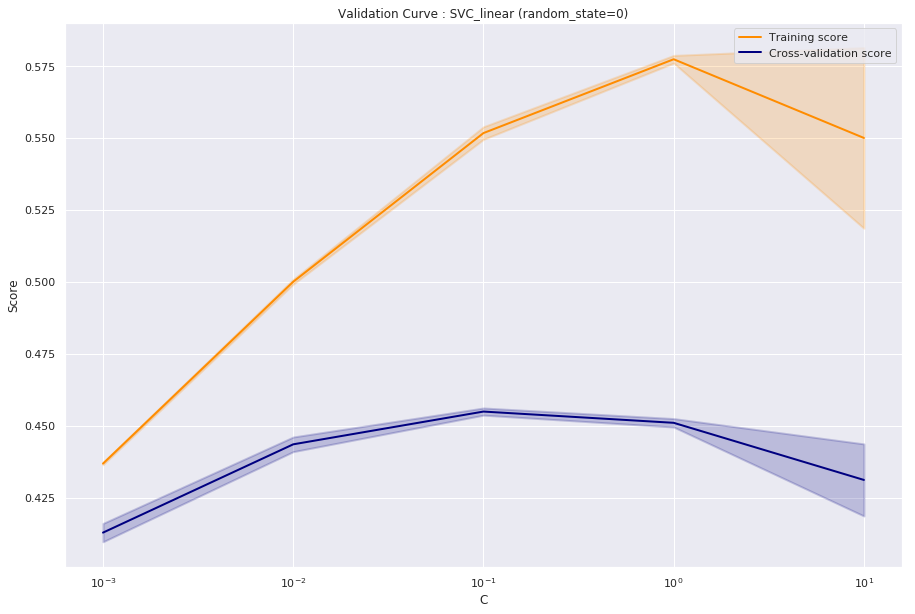

In [6]:
plot_validation_curves(models['SVC_linear'], 'SVC_linear', X_train, y_train_cla,\
                       'random_state', [0],\
                       'C', grid['SVC_linear']['C'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=0, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)


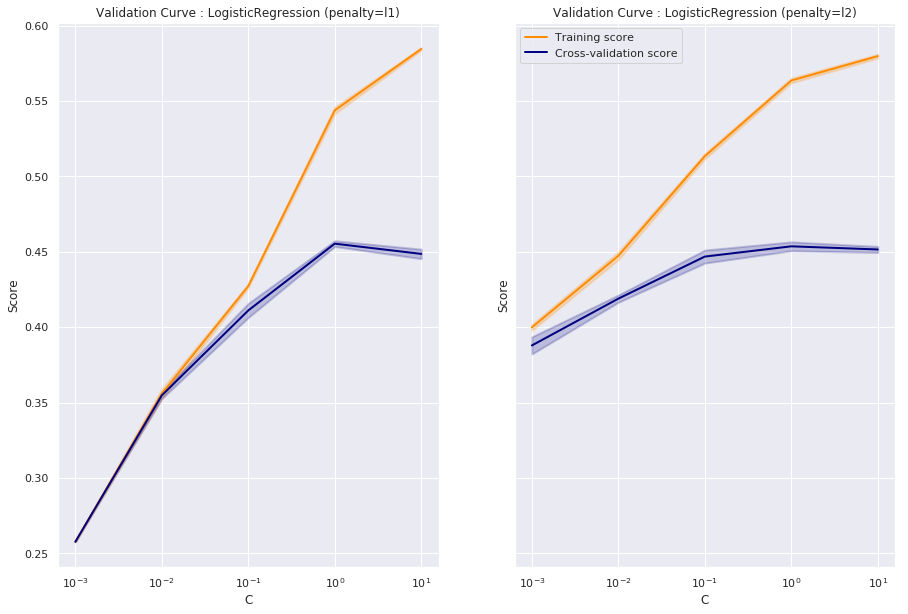

In [7]:
plot_validation_curves(models['LogisticRegression'], 'LogisticRegression', X_train, y_train_cla,\
                       'penalty', grid['LogisticRegression']['penalty'],\
                       'C', grid['LogisticRegression']['C'])

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=0, tol=0.0001, verbose=0)


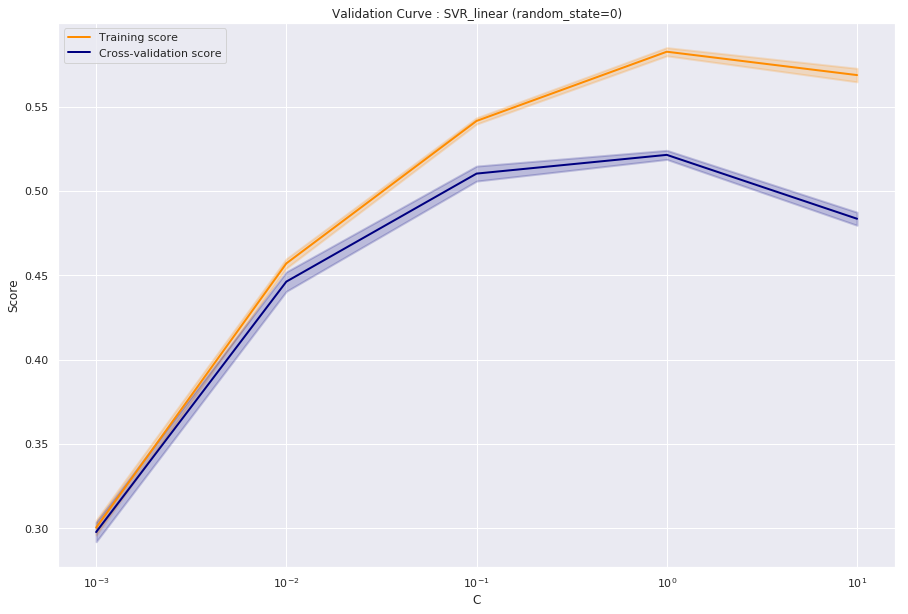

In [8]:
plot_validation_curves(models_reg['SVR_linear'], 'SVR_linear', X_train, y_train_reg,\
                       'random_state', [0],\
                       'C', grid_reg['SVR_linear']['C'])

As we can see, there is an optimal point (maximum) in each of the plotted curve. So, the choosen ranges are auitable and covers correctly the hyperparameter space.

After validating our hyperparamter ranges, we will train our models. This will take a lot of time.

In [9]:
ms_cla = ModelSelector(models, grid)
ms_reg = ModelSelector(models_reg, grid_reg, cla=False)

In [10]:
ms_cla.fit(X_train, y_train_cla, scoring='accuracy')
best, details  = ms_cla.scores(X_test, y_test_cla)
#details

Fitting model : baseline
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:    7.5s remaining:   15.1s
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:    8.6s remaining:    4.3s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    9.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting model : LogisticRegression
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   56.9s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 48.1min
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 92.2min finished


Fitting model : RandomForestClassifier
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/vagrant/anaconda3/envs/exts-ml2/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   25.6s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  8.5min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  9.6min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 18.7min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 26.9min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 42.0min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 56.8min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 73.0min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 88.9min
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed: 119.3min finished


Fitting model : SVC_linear
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   23.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed: 22.6min remaining:  5.6min
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed: 41.2min finished


Fitting model : SVC_rbf
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   17.3s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   54.7s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  6.5min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 13.1min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 22.6min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 24.0min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 25.6min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 29.6min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 34.4min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed: 36.8min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 41.5min
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed: 48.0min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 50.6min
[Parallel(

For regression models :

In [11]:
ms_reg.fit(X_train, y_train_reg, scoring='rmse')
best_reg, details_reg  = ms_reg.scores(X_test, y_test_reg)
#details_reg

Fitting model : baseline
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:    1.7s remaining:    3.5s
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:    2.9s remaining:    1.5s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting model : Lasso
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   35.9s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   46.9s
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:   54.1s remaining:   13.5s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   58.0s finished


Fitting model : Ridge
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   29.8s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   53.4s
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:  1.7min remaining:   25.0s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  1.9min finished


Fitting model : SVR_linear
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   40.2s
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:  1.5min remaining:   21.9s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  3.3min finished
/home/vagrant/anaconda3/envs/exts-ml2/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting model : SVR_rbf
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   25.4s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   34.2s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:  9.2min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed: 10.0min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 11.7min
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed: 13.8min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 14.8min
[Parallel(n_jobs=3)]: Done 175 tasks      | elapsed: 17.5min
[Parallel(n_jobs=3)]: Do

We will also train our neural networks on data :

In [12]:
y_train_cla_1h = LabelBinarizer().fit_transform(y_train_cla.values.reshape(-1, 1))
y_test_cla_1h = LabelBinarizer().fit_transform(y_test_cla.values.reshape(-1, 1))
tr_acc_dl1, tr_auc_dl1, t_acc_dl1, t_auc_dl1, y_hat_dl1 = fit_nn(nn_dl1(X_train),X_train, y_train_cla_1h, X_test, y_test_cla_1h)
tr_acc_dl1_reg, tr_auc_dl1_reg, t_acc_dl1_reg, t_auc_dl1_reg = fit_nn_reg(nn_dl1(X_train,1,'linear'),X_train, y_train_reg, X_test, y_test_reg)
tr_acc_dl2, tr_auc_dl2, t_acc_dl2, t_auc_dl2, y_hat_dl2 = fit_nn(nn_dl2(X_train),X_train, y_train_cla_1h, X_test, y_test_cla_1h)
tr_acc_dl2_reg, tr_auc_dl2_reg, t_acc_dl2_reg, t_auc_dl2_reg = fit_nn_reg(nn_dl2(X_train,1,'linear'),X_train, y_train_reg, X_test, y_test_reg)
best_nn = pd.DataFrame( [ ['nn_dl1', tr_acc_dl1, tr_auc_dl1, t_acc_dl1, t_auc_dl1], 
                          ['nn_dl1_reg', tr_acc_dl1_reg, tr_auc_dl1_reg, t_acc_dl1_reg, t_auc_dl1_reg], 
                          ['nn_dl2', tr_acc_dl2, tr_auc_dl2, t_acc_dl2, t_auc_dl2],
                          ['nn_dl2_reg', tr_acc_dl2_reg, tr_auc_dl2_reg, t_acc_dl2_reg, t_auc_dl2_reg]
                        ], columns=['model', 'best_train_score', 'best_train_auc_score', 'best_test_score', 'best_test_auc_score'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               297728    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 298,244
Trainable params: 298,244
Non-trainable params: 0
_________________________________________________________________
None
Train on 29010 samples, validate on 3224 samples
Epoch 1/30
29010/29010 [==============================] - 9s 318us/step - loss: 1.2856 - acc: 0.3820 - val_loss: 1.2165 - val_acc: 0.4377
Epoch 2/30
29010/29010 [==============================] - 8s 270us/step - loss: 1.2029 - acc: 0.4455 - val_loss: 1.1844 - val_acc: 0.4584
Epoch 3/30
29010/29010 [==============================] - 8s 270us/ste

We will also train the xgboost model :

In [13]:
tr_acc, tr_auc, t_acc, t_aux                 = fit_xgb(X_train, y_train_cla, False)
tr_acc_reg, tr_auc_reg, t_acc_reg, t_aux_reg = fit_xgb_reg(X_train, y_train_reg, False)
best_xgb = pd.DataFrame( [ ['xgb', tr_acc, tr_auc, t_acc, t_aux], 
                           ['xgb_reg', tr_acc_reg, tr_auc_reg, t_acc_reg, t_aux_reg]
              ], columns=['model', 'best_train_score', 'best_train_auc_score', 'best_test_score', 'best_test_auc_score'])


train : auc score :0.8289460696122135, accuracy score :0.5917974809207669
test : auc score :0.6866579927820428, accuracy score :0.41444347933986847
[[1102  344  277  252]
 [ 775  512  430  337]
 [ 428  412  652  574]
 [ 238  246  406 1074]]
RMSE : train score :1.6289399410425716, test score :1.7207618655305097


After traing all of our models, we will their performance on train and test data :

For classical models : 

Classifcation :

In [14]:
best

,model,params,mean_train_score,std_train_score,mean_val_score,std_val_score,best_test_score,best_test_auc_score
0,baseline,{'strategy': 'most_frequent'},0.257678,6.736974e-07,0.257678,0.000001,0.256359,0.500000
1,LogisticRegression,"{'C': 1.0, 'penalty': 'l1'}",0.543712,2.233923e-03,0.455358,0.001903,0.461348,0.642378
2,RandomForestClassifier,"{'max_depth': 30.0, 'min_samples_split': 5, 'n...",0.999984,2.193804e-05,0.421946,0.002692,0.447326,0.632650
3,SVC_linear,{'C': 0.1},0.551762,2.184928e-03,0.454985,0.001242,0.460231,0.642130
4,SVC_rbf,"{'fm__gamma': 0.1, 'fm__n_components': 500, 's...",0.467302,6.088735e-03,0.430198,0.000909,0.431567,0.623144


Regression :

In [15]:
best_reg

,model,params,mean_train_score,std_train_score,mean_val_score,std_val_score,best_test_score,best_test_auc_score
0,baseline,{'strategy': 'mean'},2.337071,0.003270,2.337149,0.006562,2.288065,NaN
1,Lasso,{'alpha': 0.001},1.664462,0.004301,1.690393,0.010636,1.686022,NaN
2,Ridge,{'alpha': 1.0},1.471164,0.003652,1.591377,0.007719,1.564269,NaN
3,SVR_linear,{'C': 1.0},1.510016,0.004485,1.616819,0.007639,1.579635,NaN
4,SVR_rbf,"{'fm__gamma': 0.1, 'fm__n_components': 500, 's...",1.620217,0.011661,1.641604,0.005480,1.631165,NaN


Neural network performance on train and test data :

In [16]:
best_nn

,model,best_train_score,best_train_auc_score,best_test_score,best_test_auc_score
0,nn_dl1,0.702023,0.903295,0.482566,0.749162
1,nn_dl1_reg,1.441225,NaN,1.541701,NaN
2,nn_dl2,0.811317,0.953425,0.478595,0.745792
3,nn_dl2_reg,0.893092,NaN,1.429074,NaN


Xgboost performance on train and test data :

In [17]:
best_xgb

,model,best_train_score,best_train_auc_score,best_test_score,best_test_auc_score
0,xgb,0.591797,0.828946,0.414443,0.686658
1,xgb_reg,1.720762,NaN,1.628940,NaN


We will aggregate of these results in a single table and chart :

In [18]:
results = pd.concat((best_nn[~best_nn.model.str.contains('reg')][['model','best_train_score','best_test_score']],
           best[['model','mean_train_score','best_test_score']].rename(columns={'mean_train_score':'best_train_score'}),
           best_xgb[~best_xgb.model.str.contains('reg')][['model','best_train_score','best_test_score']]
          )
         ).sort_values('best_test_score', ascending=False)
results

,model,best_train_score,best_test_score
0,nn_dl1,0.702023,0.482566
2,nn_dl2,0.811317,0.478595
1,LogisticRegression,0.543712,0.461348
3,SVC_linear,0.551762,0.460231
2,RandomForestClassifier,0.999984,0.447326
4,SVC_rbf,0.467302,0.431567
0,xgb,0.591797,0.414443
0,baseline,0.257678,0.256359


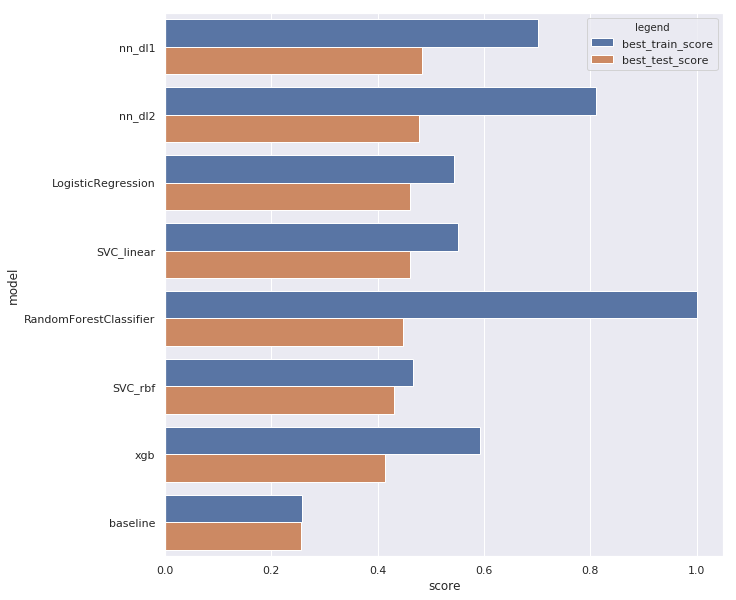

In [19]:
plt.figure(figsize=(10,10))
sns.barplot(data=pd.melt(results,var_name='legend', value_name='score', id_vars=['model'], value_vars=['best_train_score','best_test_score']),x='score',y='model',hue='legend',orient='h');

The best model for classification data is neural network with one hidden layer with an accuracy of 48%, which is better than the baseline (25%).

This model is also the best in term of roc auc metric : 75% which is better than the baseline (50%).

In [20]:
results_auc = pd.concat((best_nn[~best_nn.model.str.contains('reg')][['model','best_test_auc_score']],
           best[['model','best_test_auc_score']],
           best_xgb[~best_xgb.model.str.contains('reg')][['model','best_test_auc_score']]
          )
         ).sort_values('best_test_auc_score', ascending=False)
results_auc

,model,best_test_auc_score
0,nn_dl1,0.749162
2,nn_dl2,0.745792
0,xgb,0.686658
1,LogisticRegression,0.642378
3,SVC_linear,0.642130
2,RandomForestClassifier,0.632650
4,SVC_rbf,0.623144
0,baseline,0.500000


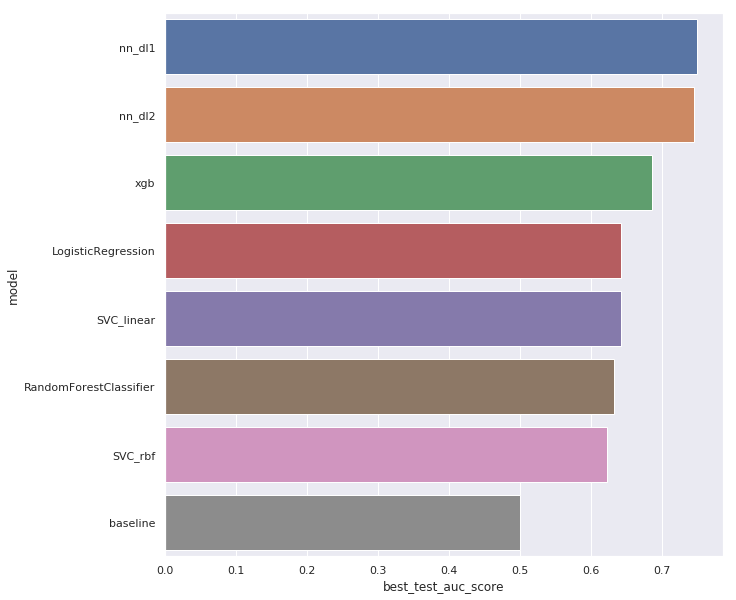

In [21]:
plt.figure(figsize=(10,10))
sns.barplot(data=results_auc,x='best_test_auc_score',y='model', orient='h');

For regression :

The best model is the neural network model with two hidden layers with an rmse score of 1.42 whic is better than baseline(2.28).

In [22]:
results_reg = pd.concat((best_nn[best_nn.model.str.contains('reg')][['model','best_train_score','best_test_score']],
           best_reg[['model','mean_train_score','best_test_score']].rename(columns={'mean_train_score':'best_train_score'}),
           best_xgb[best_xgb.model.str.contains('reg')][['model','best_train_score','best_test_score']]
          )
         ).sort_values('best_test_score', ascending=False)
results_reg

,model,best_train_score,best_test_score
0,baseline,2.337071,2.288065
1,Lasso,1.664462,1.686022
4,SVR_rbf,1.620217,1.631165
1,xgb_reg,1.720762,1.628940
3,SVR_linear,1.510016,1.579635
2,Ridge,1.471164,1.564269
1,nn_dl1_reg,1.441225,1.541701
3,nn_dl2_reg,0.893092,1.429074


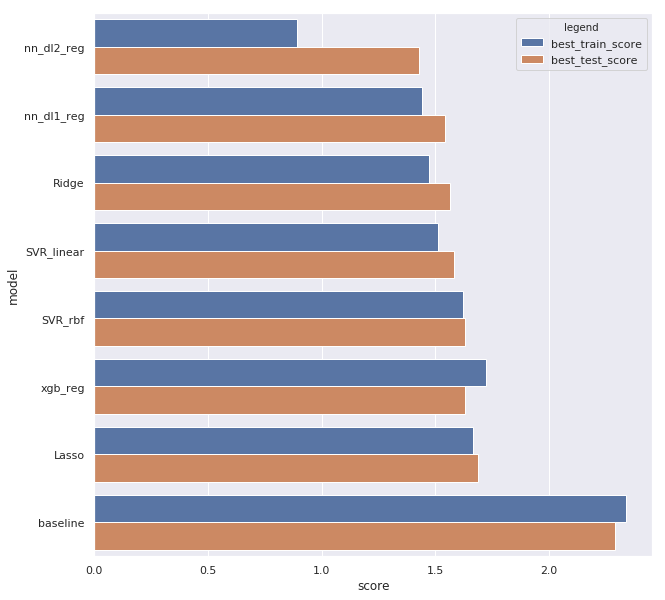

In [23]:
plt.figure(figsize=(10,10))
sns.barplot(data=pd.melt(results_reg, var_name='legend', value_name='score', id_vars=['model'], value_vars=['best_train_score','best_test_score']).sort_values('score', ascending=True)
            ,x='score',y='model',hue='legend',orient='h');

For the best model, we will show the classification report and confusion matrix :

In [24]:
classes = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test_cla, np.argmax(y_hat_dl1,axis=1), target_names=classes))

              precision    recall  f1-score   support

     class 0       0.48      0.60      0.53      1975
     class 1       0.40      0.30      0.35      2054
     class 2       0.43      0.41      0.42      2066
     class 3       0.61      0.63      0.62      1964

   micro avg       0.48      0.48      0.48      8059
   macro avg       0.48      0.49      0.48      8059
weighted avg       0.48      0.48      0.48      8059



As we can see, the classes 0 and 3 (Low and Very high) are the best predicted classes.

In [25]:
cm = confusion_matrix(y_test_cla, np.argmax(y_hat_dl1,axis=1))
cm

array([[1194,  377,  274,  130],
       [ 745,  625,  451,  233],
       [ 383,  404,  839,  440],
       [ 172,  157,  404, 1231]])

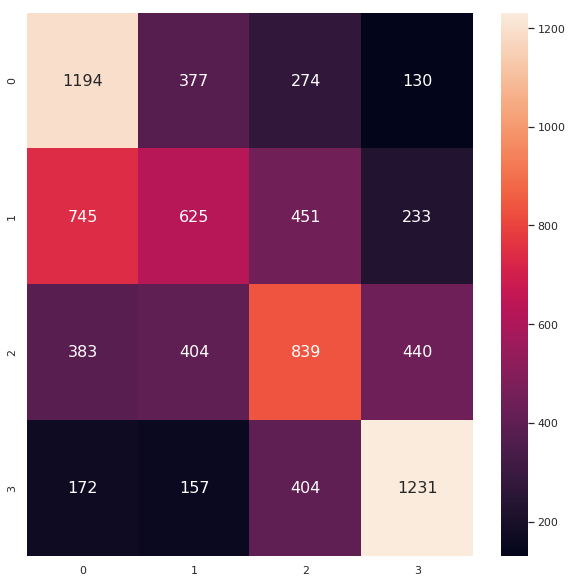

In [26]:
plt.figure(figsize=(10,10))
df_cm = pd.DataFrame(cm, np.arange(4), np.arange(4))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d');

In the confusion maxtrix, we can see that it's more difficult for our classifiers to separate between adjacent classes. Nevertheless, there is also misclassification for classes that are not adjacent (for example, 0 and 3). 

Performance impact after adding image features

In [27]:
X_train = pd.concat((X_train_base.book_pages_log,authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, image_df_train), axis=1)
X_test = pd.concat((X_test_base.book_pages_log,authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, image_df_test), axis=1)
print(X_train.shape, X_test.shape)
tr_acc_dl1, tr_auc_dl1, t_acc_dl1, t_auc_dl1, _ = fit_nn(nn_dl1(X_train),X_train, y_train_cla_1h, X_test, y_test_cla_1h)
tr_acc_dl1_reg, tr_auc_dl1_reg, t_acc_dl1_reg, t_auc_dl1_reg = fit_nn_reg(nn_dl1(X_train,1,'linear'),X_train, y_train_reg, X_test, y_test_reg)
tr_acc_dl2, tr_auc_dl2, t_acc_dl2, t_auc_dl2, _ = fit_nn(nn_dl2(X_train),X_train, y_train_cla_1h, X_test, y_test_cla_1h)
tr_acc_dl2_reg, tr_auc_dl2_reg, t_acc_dl2_reg, t_auc_dl2_reg = fit_nn_reg(nn_dl2(X_train,1,'linear'),X_train, y_train_reg, X_test, y_test_reg)
best_nn_with_image = pd.DataFrame( [ ['nn_dl1', tr_acc_dl1, tr_auc_dl1, t_acc_dl1, t_auc_dl1], 
                          ['nn_dl1_reg', tr_acc_dl1_reg, tr_auc_dl1_reg, t_acc_dl1_reg, t_auc_dl1_reg], 
                          ['nn_dl2', tr_acc_dl2, tr_auc_dl2, t_acc_dl2, t_auc_dl2],
                          ['nn_dl2_reg', tr_acc_dl2_reg, tr_auc_dl2_reg, t_acc_dl2_reg, t_auc_dl2_reg]
                        ], columns=['model', 'best_train_score', 'best_train_auc_score', 'best_test_score', 'best_test_auc_score'])

(32234, 4373) (8059, 4373)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               559872    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 560,388
Trainable params: 560,388
Non-trainable params: 0
_________________________________________________________________
None
Train on 29010 samples, validate on 3224 samples
Epoch 1/30
29010/29010 [==============================] - 17s 577us/step - loss: 1.3861 - acc: 0.2640 - val_loss: 1.3804 - val_acc: 0.2996
Epoch 2/30
29010/29010 [==============================] - 15s 522us/step - loss: 1.3635 - acc: 0.3012 - val_loss: 1.3547 - val_acc: 0.3434
Epoch 3/30
29010/29010 [=================

In [28]:
best_nn

,model,best_train_score,best_train_auc_score,best_test_score,best_test_auc_score
0,nn_dl1,0.702023,0.903295,0.482566,0.749162
1,nn_dl1_reg,1.441225,NaN,1.541701,NaN
2,nn_dl2,0.811317,0.953425,0.478595,0.745792
3,nn_dl2_reg,0.893092,NaN,1.429074,NaN


In [29]:
best_nn_with_image

,model,best_train_score,best_train_auc_score,best_test_score,best_test_auc_score
0,nn_dl1,0.429826,0.712851,0.403772,0.688764
1,nn_dl1_reg,1.542524,NaN,1.646006,NaN
2,nn_dl2,0.621549,0.861331,0.429458,0.705773
3,nn_dl2_reg,1.338845,NaN,1.576573,NaN


As we can see, after adding image features, the performance of the models becomes worse.

Our decision to exclude image features from traiing data was right.

Now, we will store results on disk.

In [30]:
results.to_pickle("results.pkl")
results_auc.to_pickle("results_auc.pkl")
results_reg.to_pickle("results_reg.pkl")
best_nn_with_image.to_pickle("best_nn_with_image.pkl")
np.save('y_pred_nn.npy', y_hat_dl1)
np.save('y_test_cla.npy', y_test_cla)